In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
from typing import NamedTuple
from collections import namedtuple
%matplotlib inline

In [2]:
from datastore_pytables import Store

In [3]:
store = Store()
store.keys()

['/cont/min/CL_20191120_NYMEX_USD',
 '/cont/min/ES_20191220_GLOBEX_USD',
 '/cont/min/GC_20191227_NYMEX_USD',
 '/cont/min/GE_20191216_GLOBEX_USD',
 '/cont/min/NKD_20191212_GLOBEX_USD',
 '/cont/min/NQ_20191220_GLOBEX_USD',
 '/cont/min/YM_20191220_ECBOT_USD',
 '/cont/min/ZB_20191219_ECBOT_USD',
 '/cont/min/ZF_20191231_ECBOT_USD',
 '/cont/min/ZN_20191219_ECBOT_USD']

In [4]:
multiplier = 20
#periods = 20
periods = [5, 10, 20, 40, 80, 160] 
ema_fast = 5
ema_slow = 120 # number of periods for moving average filter
#sl_atr = 1 # stop loss in ATRs
atr_periods = 180 # number of periods to calculate ATR on
time_int = 30 # interval in minutes to be used to define volume candle
commission = 2.1 # level of commision per transaction in dollars
bankroll = 15000

In [5]:
contract = store.read('/cont/min/GC_20191227_NYMEX_USD').sort_index()
#contract = pd.read_pickle('data/minute_GC_cont_non_active_included.pickle')
contract = contract.loc['20190101': '20191231']

In [6]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

5984.930719616634

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
"""
vol_candles = contract.resample('30min').agg({'open': 'first',
                                           'high': 'max',
                                           'low': 'min',
                                           'close': 'last',
                                           'volume': 'sum',
                                           'barCount': 'sum'}).reset_index().dropna()
"""
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2019-01-02 02:11:00,1285.0,1285.0,1281.1,1281.5,2712,5875,3.900000
1,2019-01-02 03:19:00,1281.5,1283.2,1280.8,1282.9,2651,6391,3.145833
2,2019-01-02 04:27:00,1283.0,1285.2,1282.7,1285.2,2757,6099,2.928159
3,2019-01-02 06:17:00,1285.1,1286.2,1284.1,1285.9,2330,4894,2.717656
4,2019-01-02 06:56:00,1285.8,1288.4,1285.8,1287.9,2856,7176,2.693599
...,...,...,...,...,...,...,...,...
9371,2019-11-01 16:35:00,1513.1,1513.8,1511.7,1511.8,2997,6423,2.189796
9372,2019-11-01 16:56:00,1511.8,1513.5,1511.7,1512.4,2818,6188,2.185489
9373,2019-11-01 17:18:00,1512.4,1514.2,1512.4,1514.2,2377,5695,2.181230


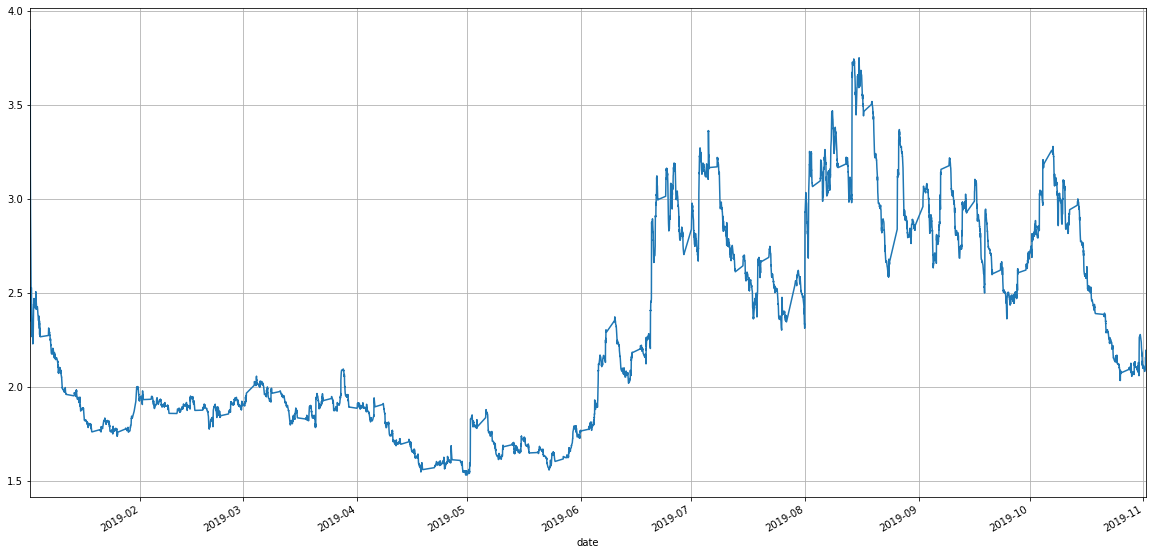

In [8]:
chart = vol_candles.set_index('date')
chart.atr.plot(figsize=(20,10), grid=True);

In [9]:
vol_candles.atr.mean(), vol_candles.atr.median()

(2.4110555088742243, 2.430811799703476)

In [10]:
#vol_candles['atr'] = 20

In [11]:
data = vol_candles.copy()
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()
data['ema_slow'] = data.close.ewm(span=ema_slow).mean()
#data['min'] = data.close.rolling(periods).min()
#data['max'] = data.close.rolling(periods).max()
rows_to_drop = max(*periods, ema_slow)
#rows_to_drop = max(periods, ema_fast)
data = data.iloc[rows_to_drop:]
data.reset_index(drop=True, inplace=True)

In [12]:
#data['buy_signal'] = (data.close >= data['max']) * 1
#data['sell_signal'] = (data.close <= data['min']) * -1
#data['signal'] = data.buy_signal + data.sell_signal
#del data['buy_signal']
#del data['sell_signal']
data['signal'] = get_signals(data.close, periods)
data['filter'] = np.sign(data['ema_fast'] - data['ema_slow'])
data['filtered_signal'] = data['signal'] * ((data['signal'] * data['filter']) == 1)
#data['filtered_signal'] = data['signal']

In [13]:
data.rename(columns={'open': 'price'}, inplace=True)

In [14]:
b = c_backtester(data, sl_atr=1, trailing_sl=True, active_close=True, block_stop=False, take_profit=0)
#results_c = perf(b, multiplier, bankroll) 

Annual return                   0.19365
Cumulative returns             0.163027
Annual volatility             0.0734141
Sharpe ratio                    2.44845
Calmar ratio                    6.59975
Stability                      0.928342
Max drawdown                 -0.0293421
Omega ratio                     1.55921
Sortino ratio                   4.69856
Skew                            1.00356
Kurtosis                        3.16433
Tail ratio                      1.87542
Daily value at risk         -0.00853601
Win percent                    0.407625
Average gain                    5.22302
Average loss                   -2.55941
Avg gain/loss ratio             2.04072
Position EV                    0.612903
Positions per day               1.58605
Days per position              0.630499
Actual avg. duration    0 days 05:11:00
Days                                215
Positions                           341
Trades                              682
Monthly EV                       20.414


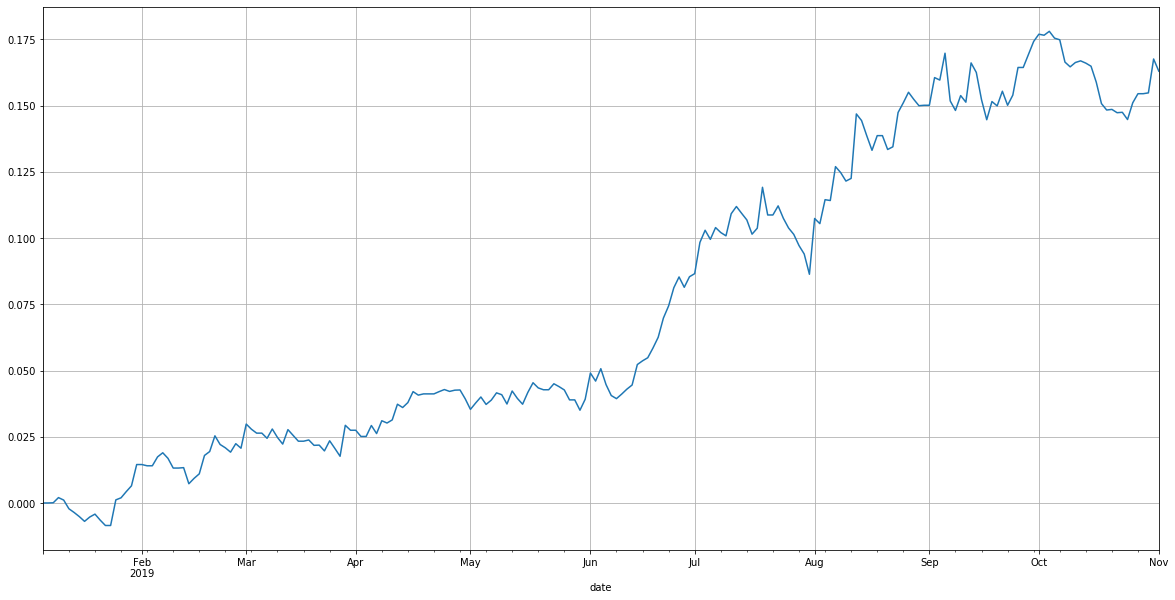

In [15]:
results = perf(b) 

In [16]:
prices = data.set_index('date').close.resample('B').last()
returns = prices.pct_change().fillna(0)
vols_returns = returns.ewm(span=5).std()
vols_prices = vols_returns * prices

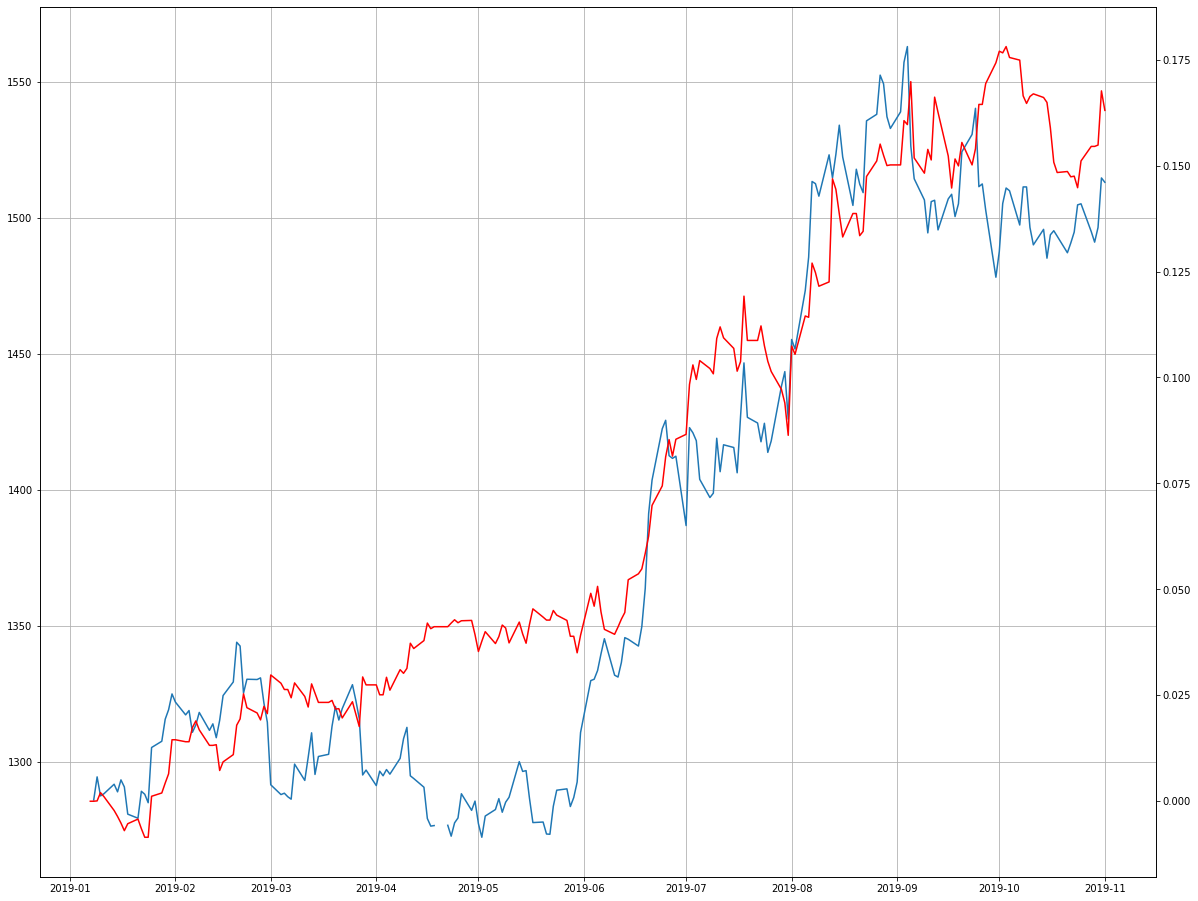

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)
ax.plot(prices)
ax1 = ax.twinx()
ax1.plot(results.daily.path, color='red')
ax.grid()
plt.show();

In [18]:
monthly = pd.DataFrame({'open': results.daily.balance.resample('M').first(),
                        'close': results.daily.balance.resample('M').last()})
monthly['c'] = monthly['close'].shift().fillna(monthly['open'].iloc[0])
monthly['pnl'] = monthly['close'] - monthly['c']
del monthly['open']
monthly.columns = ['close', 'open', 'pnl']
monthly

,close,open,pnl
date,,,
2019-01-31,1300.6,1282.0,18.6
2019-02-28,1308.5,1300.6,7.9
2019-03-31,1317.2,1308.5,8.7
2019-04-30,1332.4,1317.2,15.2
2019-05-31,1332.2,1332.4,-0.2
2019-06-30,1391.5,1332.2,59.3
2019-07-31,1392.7,1391.5,1.2
2019-08-31,1474.5,1392.7,81.8
2019-09-30,1505.4,1474.5,30.9


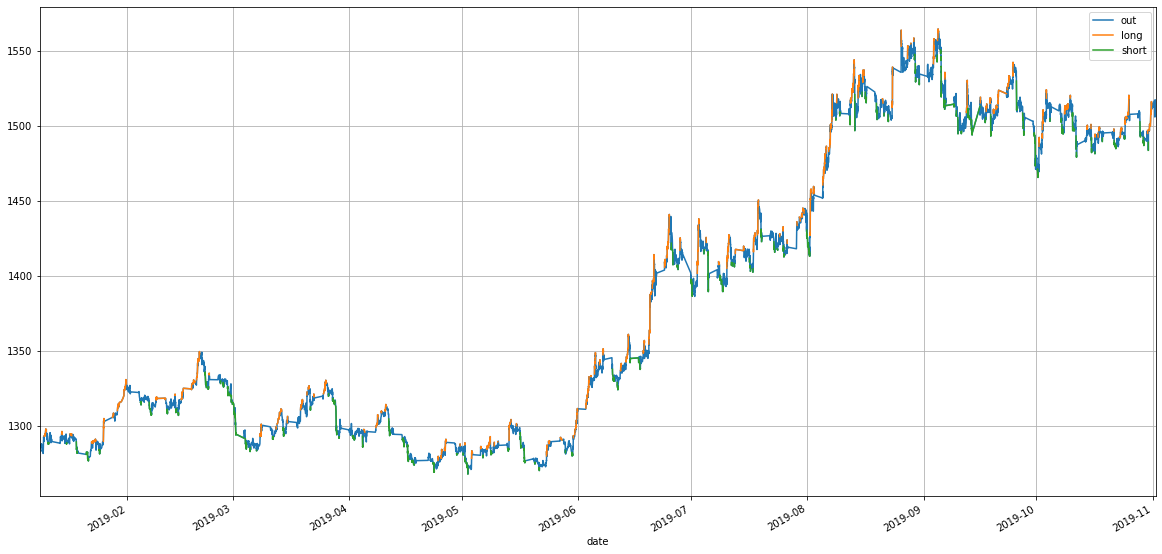

In [19]:
a = chart_price(b['price'], b['position'])

In [20]:
results.positions.sort_values('pnl')

,date_o,open,date_c,close,reason,pnl,duration
260,2019-09-06 14:25:00,-1511.1,2019-09-06 14:33:00,1522.8,stop-out,-11.7,0 days 00:08:00
271,2019-09-13 20:59:00,-1495.9,2019-09-16 00:25:00,1507.2,stop-out,-11.3,2 days 03:26:00
191,2019-07-19 00:20:00,1450.5,2019-07-19 00:34:00,-1443.3,stop-out,-7.2,0 days 00:14:00
172,2019-07-05 02:13:00,1425.5,2019-07-05 03:20:00,-1419.9,stop-out,-5.6,0 days 01:07:00
201,2019-07-29 05:36:00,1436.0,2019-07-29 09:56:00,-1430.6,stop-out,-5.4,0 days 04:20:00
...,...,...,...,...,...,...,...
190,2019-07-18 17:51:00,1427.4,2019-07-19 00:09:00,-1446.9,stop-out,19.5,0 days 06:18:00
151,2019-06-19 22:16:00,1359.5,2019-06-20 03:24:00,-1379.2,stop-out,19.7,0 days 05:08:00
210,2019-08-01 17:31:00,1427.0,2019-08-01 20:07:00,-1448.0,stop-out,21.0,0 days 02:36:00
226,2019-08-12 20:41:00,1519.0,2019-08-13 12:59:00,-1540.2,stop-out,21.2,0 days 16:18:00


In [21]:
#results.daily.to_pickle('GC_30_2019.pickle')